In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit
from datasets import Dataset

In [2]:
dataset = load_dataset("go_emotions", "raw")

In [3]:
dataset.set_format(type= "pandas")
df = dataset["train"][:]
df.head(3)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
# count the number of tokens in the entire dataset
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
df["num_tokens"] = df["text"].apply(lambda x: len(tokenizer(x)["input_ids"]))
# print the total number
print("Total number of tokens in the dataset:", df["num_tokens"].sum())

Token indices sequence length is longer than the specified maximum sequence length for this model (1437 > 512). Running this sequence through the model will result in indexing errors


Total number of tokens in the dataset: 4036915


In [4]:
print(len(df))

211225


In [5]:
print(df['text'][:5])

0                                      That game hurt.
1     >sexuality shouldn’t be a grouping category I...
2       You do right, if you don't care then fuck 'em!
3                                   Man I love reddit.
4    [NAME] was nowhere near them, he was by the Fa...
Name: text, dtype: object


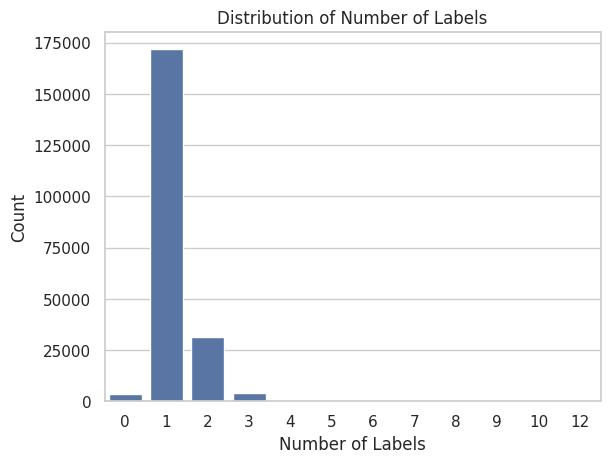

In [6]:
# Count of each label
df['num_labels'] = df.iloc[:, 9:].sum(axis=1)

sns.set(style="whitegrid")

fig, ax = plt.subplots()
label_counts = df['num_labels'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax)

ax.set_title('Distribution of Number of Labels')
ax.set_xlabel('Number of Labels')
ax.set_ylabel('Count')
plt.show()

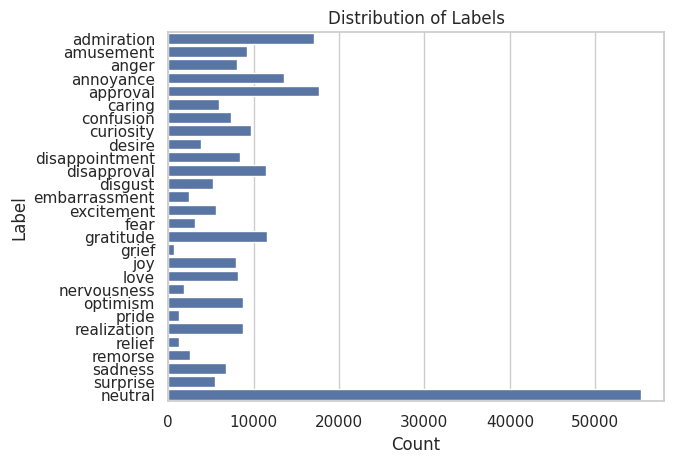

In [7]:
# Plotting the distribution of labels

label_counts = df.iloc[:, 9:].sum(axis=0)
label_counts = label_counts.drop('num_labels')

fig, ax = plt.subplots()
sns.barplot(x=label_counts.values, y=label_counts.index, ax=ax)

ax.set_title('Distribution of Labels')
ax.set_xlabel('Count')
ax.set_ylabel('Label')
plt.show()


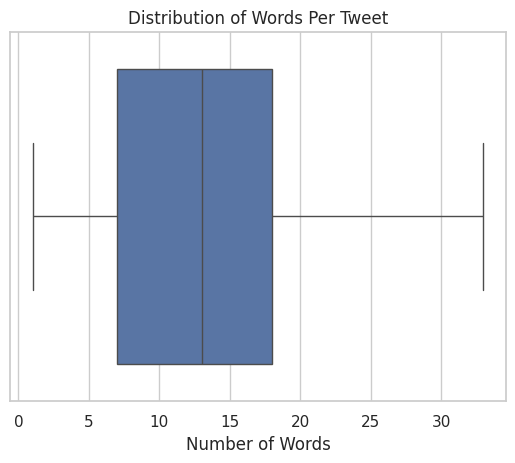

In [8]:
df['Words_Per_Tweet'] = df['text'].apply(lambda x: len(x.split()))

# Creating a boxplot for the number of words in each tweet
fig, ax = plt.subplots()
sns.boxplot(x='Words_Per_Tweet', data=df, ax=ax)

ax.set_title('Distribution of Words Per Tweet')
ax.set_xlabel('Number of Words')
plt.show()


In [9]:
df.drop('num_labels', axis=1, inplace=True)
df.drop('Words_Per_Tweet', axis=1, inplace=True)

In [10]:
model_checkpoint = "distilbert/distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [11]:
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"Max model input length: {tokenizer.model_max_length}")
print(f"Input names: {tokenizer.model_input_names}")

Tokenizer vocab size: 50265
Max model input length: 512
Input names: ['input_ids', 'attention_mask']


In [12]:
num_labels = 28
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

# Combining all features into a string for stratification


binary_columns = df.columns[9:]

def row_to_bitstring(row):
    return ''.join(str(int(value)) for value in row[binary_columns])

df['multilabel_column'] = df.apply(row_to_bitstring, axis=1)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
X = df[['text']]
y = df['multilabel_column']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform stratified train-test split
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

/home/amin/miniconda3/envs/main/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


/tmp/ipykernel_1065/686041161.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop('multilabel_column', axis=1, inplace=True)
/tmp/ipykernel_1065/686041161.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop('multilabel_column', axis=1, inplace=True)


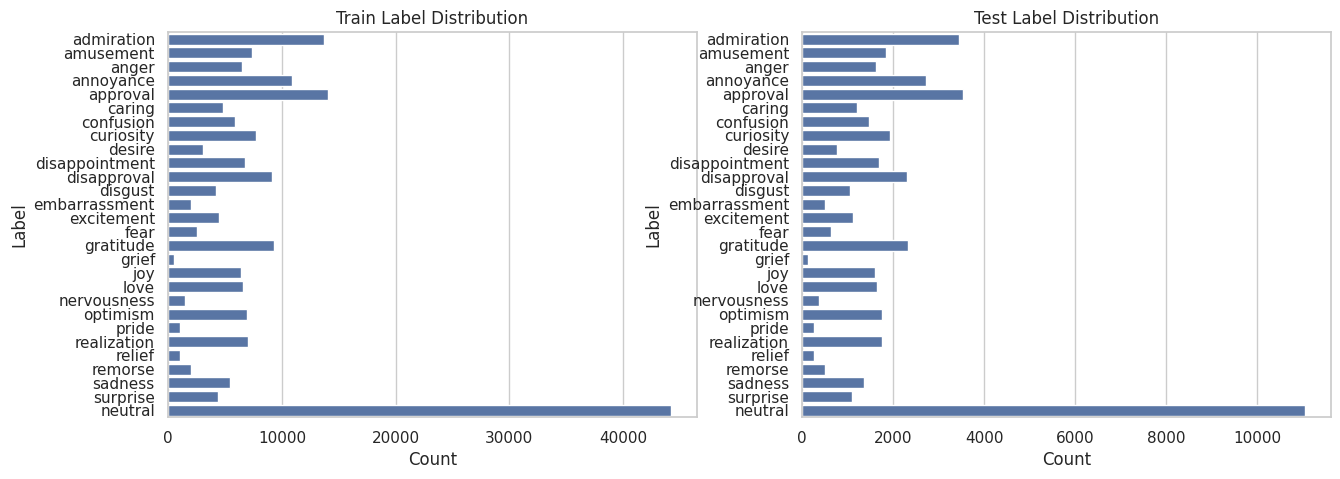

In [14]:
# check distribution of labels in train and test set
train_df = df.iloc[train_index]
test_df = df.iloc[test_index]
train_df.drop('multilabel_column', axis=1, inplace=True)
test_df.drop('multilabel_column', axis=1, inplace=True)


train_label_counts = train_df.iloc[:, 9:].sum(axis=0)

test_label_counts = test_df.iloc[:, 9:].sum(axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=train_label_counts.values, y=train_label_counts.index, ax=ax[0])
sns.barplot(x=test_label_counts.values, y=test_label_counts.index, ax=ax[1])

ax[0].set_title('Train Label Distribution')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Label')

ax[1].set_title('Test Label Distribution')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Label')

plt.show()

In [15]:
train_df = df.iloc[train_index]
test_df = df.iloc[test_index]

def tokenize_function(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True)

# tokenize the Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=512)
test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=512)

# back to a pandas DataFrame
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()

train_df.drop('multilabel_column', axis=1, inplace=True)
test_df.drop('multilabel_column', axis=1, inplace=True)


Map:   0%|          | 0/168980 [00:00<?, ? examples/s]

Map:   0%|          | 0/42245 [00:00<?, ? examples/s]

In [16]:
class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_ids = self.df.iloc[idx, 38]
        attention_mask = self.df.iloc[idx, 39]
        labels = np.array(self.df.iloc[idx, 9:37])
        labels = labels.astype(np.float32)

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

train_dataset = MultiLabelDataset(train_df)
test_dataset = MultiLabelDataset(test_df)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


In [23]:
def custom_loss_function(logits, labels):
    loss_fct = torch.nn.BCEWithLogitsLoss()
    loss = loss_fct(logits, labels)
    return loss


We need to fix the `compute metrics` function, maybe by first debugging the error, and possibly fixing it with another function. 

In [27]:
from transformers import Trainer
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,
    save_total_limit=10,
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    greater_is_better=True
)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss, roc_curve

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    threshold = 0.5

    preds = (preds > threshold).astype(int)

    precision_micro = precision_score(labels, preds, average='macro', zero_division=0)
    recall_micro = recall_score(labels, preds, average='macro', zero_division=0)
    f1_micro = f1_score(labels, preds, average='macro', zero_division=0)
    accuracy = accuracy_score(labels, preds)

    # Add the expected keys
    metrics = {
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'eval_accuracy': accuracy,  # For Hugging Face Trainer
        'eval_f1': f1_micro,  # For Hugging Face Trainer
    }

    return metrics

# Define the trainer
class MultiLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = custom_loss_function(logits, labels)
        return (loss, outputs) if return_outputs else loss
    
trainer = MultiLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)



/home/amin/miniconda3/envs/main/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
# evaluate the accuray, recall, precision, f1 for per label for the test set

# predict the test set
predictions, labels, _ = trainer.predict(test_dataset)

threshold = 0.5

predictions = (predictions > threshold).astype(int)

# calculate the metrics for each label
precision = precision_score(labels, predictions, average=None)
recall = recall_score(labels, predictions, average=None)
f1 = f1_score(labels, predictions, average=None)
accuracy = accuracy_score(labels, predictions)

# create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Label': binary_columns,
    'Precision': precision,
    'Recall': recall,
    'F1': f1
})

print(metrics_df)

In [ ]:
# get a multi-label prediction
def predict(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    logits = output.logits

    # apply sigmoid
    probs = torch.sigmoid(logits)
    probs = probs.detach().numpy()

    # threshold at 0.5 to get the predicted labels
    threshold = 0.5
    predicted_labels = np.where(probs > threshold, 1, 0)
    predicted_labels = predicted_labels[0]

    # get it's location in the binary columns
    predicted_labels = np.where(predicted_labels == 1)[0]

    return predicted_labels

# predict a sample
text = "I am so happy today!"
predicted_labels = predict(text)
print(predicted_labels)


In [23]:
# check if the sum of numbers between column 9 and 37 is greater than two, if so return the sample
def get_sample_with_multiple_labels(df):
    for i in range(len(df)):
        if df.iloc[i, 9:37].sum() > 1:
            return df.iloc[i, 0] , i
        
sample, i = get_sample_with_multiple_labels(train_df)
print(sample)
print(i)

That is odd.
9


In [24]:
train_df.iloc[i, 9:37]

admiration        0
amusement         0
anger             0
annoyance         0
approval          0
caring            0
confusion         0
curiosity         0
desire            0
disappointment    1
disapproval       0
disgust           1
embarrassment     0
excitement        0
fear              0
gratitude         0
grief             0
joy               0
love              0
nervousness       0
optimism          0
pride             0
realization       0
relief            0
remorse           0
sadness           0
surprise          0
neutral           0
Name: 9, dtype: object